In [25]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
import onnx

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils import data
from pycocotools.coco import COCO
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [28]:
def get_model(num_classes):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="COCO_V1")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.8, weight_decay=0.005)

    return model, optimizer

In [29]:
model, optimizer = get_model(3)

In [30]:
model.load_state_dict(torch.load("/content/drive/MyDrive/TestTask/model_weights.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
@torch.no_grad()
def evaluate(image, model):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model.eval()
    image = Image.open(image)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((640, 640))])

    image_transformed = transform(image).float()
    image_transformed = image_transformed.unsqueeze_(0)
    image_transformed = image_transformed.to(device)

    prediction = model(image_transformed)

    return prediction


def visualize(image, predictions):
    print(predictions)
    image = Image.open(image)
    image = image.resize((640, 640))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    box_list = [
        {
            "box": box,
            "class": predictions[0]["labels"][index],
            "score": predictions[0]["scores"][index]
        } for index, box in enumerate(predictions[0]["boxes"])
                if predictions[0]["scores"][index] > 0.8
        ]

    for entry in box_list:
        box = entry["box"]
        label = entry["class"]
        score = entry["score"]

        box = box.cpu().detach().numpy()

        color = 'r' if label == 1 else 'b'
        name = 'cat' if label == 1 else 'dog'

        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none',
                                 )
        ax.text(box[0] + 2, box[1] + 12, f"{name}: {score}",
                                 fontweight=500,
                                 fontsize=13)
        ax.add_patch(rect)

    plt.show()


def predict(image, model):
    predictions = evaluate(image, model)
    visualize(image, predictions)

[{'boxes': tensor([[200.6930,  39.0702, 605.9723, 599.9384],
        [ 51.1168, 278.0306, 237.5876, 596.5571],
        [ 37.3417, 268.5860, 234.9055, 597.7670],
        [204.8313,  54.3650, 616.2960, 606.3220]]), 'labels': tensor([2, 1, 2, 1]), 'scores': tensor([0.9880, 0.8589, 0.2899, 0.2694])}]


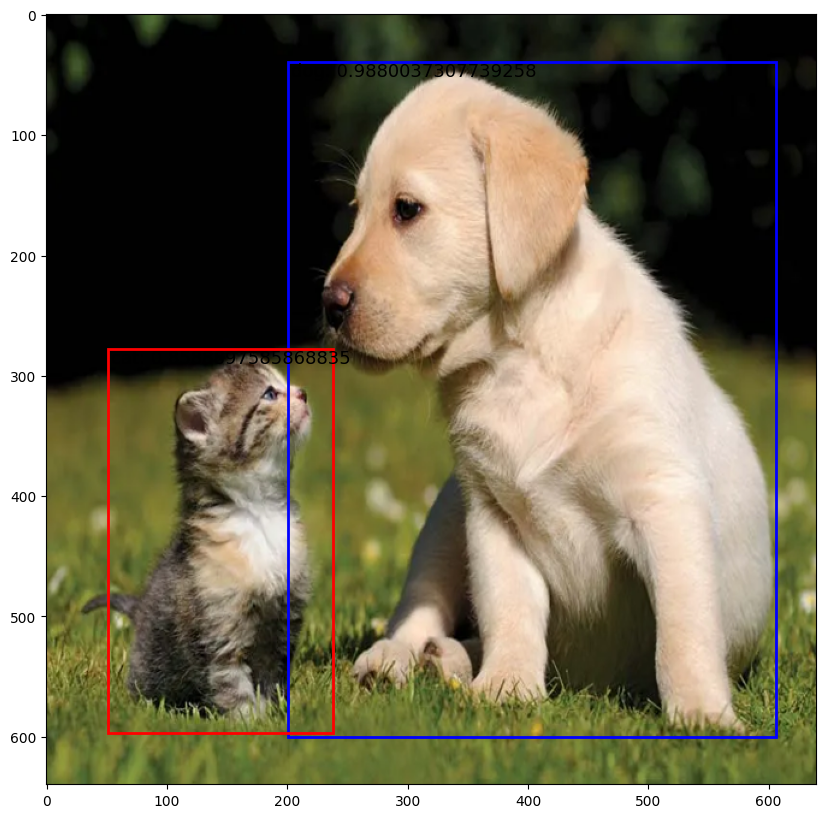

In [34]:
predict("kitten_and_puppy.jpg", model)

# Converting into an ONNX

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
image = Image.open("/content/kitten_and_puppy.jpg")
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((640, 640))])

image_transformed = transform(image).float()
image_transformed = image_transformed.unsqueeze_(0)
example = image_transformed.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [37]:
torch.onnx.export(
    model=model,
    args=torch.tensor(example),
    f="/content/model.onnx",
    verbose=False,
    export_params=True,
    input_names=['input'],
    output_names=['output']
)

<ipython-input-37-0de3e3cc3f6c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  args=torch.tensor(example),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/loca

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [38]:
onnx_model = onnx.load("/content/model.onnx")
onnx.checker.check_model(onnx_model)

# Converting from ONNX to TensorFlow Graph

In [ ]:
!pip install onnx git+https://github.com/onnx/onnx-tensorflow.git#egg=onnx-tf
!pip install onnx-simplifier onnxruntime
!pip install openvino_dev
!pip install tensorflow_datasets git+https://github.com/PINTO0309/openvino2tensorflow.git#egg=openvino2tensorflow
!pip install protobuf==3.20.3

In [14]:
import sys
import os

ONNX_MODEL_PATH = "/content/model.onnx"
WORKING_DIR = "/content"
MODEL_NAME = os.path.basename(ONNX_MODEL_PATH)[:-len('.onnx')]

# Import the model optimizer tool from the openvino_dev package
from openvino.tools.mo import main as mo_main
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load(ONNX_MODEL_PATH)
tf_rep = prepare(onnx_model)

# Get the input tensor shape
input_tensor = tf_rep.signatures[tf_rep.inputs[0]]
input_shape = input_tensor.shape
input_shape_str = '[' + ','.join([str(x) for x in input_shape]) + ']'


openvino_out_dir = f'{WORKING_DIR}/openvino'
os.makedirs(openvino_out_dir, exist_ok=True)


openvino2tensorflow_out_dir = f'{WORKING_DIR}/openvino2tensorflow'
openvino_xml_name = os.path.basename(ONNX_MODEL_PATH)[:-len('.onnx')] + '.xml'


if os.name == 'nt':
  openvino2tensorflow_exe_cmd = [sys.executable, os.path.join(os.path.dirname(sys.executable), 'openvino2tensorflow')]
else:
  openvino2tensorflow_exe_cmd = ['openvino2tensorflow']


In [22]:
!ls -a openvino2tensorflow

.  ..


In [ ]:
!pip install --upgrade pip
!pip install silabs-mltk

In [18]:
import os
from mltk.utils.shell_cmd import run_shell_cmd


print(f'Generating openvino at: {openvino_out_dir}')
cmd = [
    sys.executable, mo_main.__file__,
    '--input_model', ONNX_MODEL_PATH,
    '--input_shape', input_shape_str,
    '--output_dir', openvino_out_dir

]
retcode, retmsg = run_shell_cmd(cmd,  outfile=sys.stdout)
assert retcode == 0, 'Failed to do conversion'

print(f'Generating openvino2tensorflow model at: {openvino2tensorflow_out_dir} ...')
cmd = openvino2tensorflow_exe_cmd + [
    '--model_path', f'{openvino_out_dir}/{openvino_xml_name}',
    '--model_output_path', openvino2tensorflow_out_dir,
    '--output_saved_model',
    '--output_no_quant_float32_tflite'
]

retcode, retmsg = run_shell_cmd(cmd)
assert retcode == 0, retmsg
print('done')

Generating openvino at: /content/openvino
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /content/openvino/model.xml
[ SUCCESS ] BIN file: /content/openvino/model.bin
Generating openvino2tensorflow model at: /content/openvino2tensorflow ...


AssertionError: ignored

In [23]:
!cp "/content/model.onnx" "/content/drive/MyDrive/TestTask/model.onnx"